In [1]:

import pygame
import random
import os
import time
import numpy as np
import math
import torch
import torch.nn.functional
import matplotlib.pyplot as plt
import torch.optim as opt
from torch.autograd import Variable
from sklearn.model_selection import train_test_split

import scipy.stats as st
from sklearn.datasets.samples_generator import make_blobs
from matplotlib.colors import LogNorm 
import matplotlib.cm as cm
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from scipy.interpolate import griddata
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"  

print(dev)



pygame 2.0.1 (SDL 2.0.14, Python 3.8.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


D:\ComputerSoftwares\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


cuda:0


In [2]:
global temp_list
temp_list = []
Agent_number_n=4;
Alpha = 0.666 

# Hyper Parameters
echo = 1000 
BATCH_SIZE = 64
LR_G = 0.001           # learning rate for generator
LR_D = 0.001           # learning rate for discriminator
N_IDEAS = Agent_number_n             # think of this as number of ideas for generating an art work (Generator)
ART_COMPONENTS = Agent_number_n     # it could be total point G can draw in the canvas

Is_GAN = True # if use Gan

def Generate_distribution(Agent_number_n):
    return np.random.rand(Agent_number_n)
    #return np.random.normal(normalloc,normalscale,Agent_number_n)

In [3]:
def appen(_x_list,y):
    global temp_list
    temp_list.append(_x_list)
    
def appen_train(x_list):
    global temp_list
                
    S= max(sum(x_list),1.0);
    temp_list = []
    
    for i in range(Agent_number_n):
        temp = []
        for j in range(Agent_number_n):
            if(i!=j):
                temp.append(x_list[j])
        appen(temp,S)
    
    temp_list = np.array(temp_list)
    x_list = np.array(x_list)
    return temp_list,S,x_list
    

def appen_test(x_list):
    global temp_list
                
    S= max(sum(x_list),1.0);
    temp_list = []
    
    for i in range(Agent_number_n):
        temp = []
        for j in range(Agent_number_n):
            if(i!=j):
                temp.append(x_list[j])
        appen(temp,S)
    testing_data.append(temp_list)
    testing_label.append(S)
    temp_list = np.array(temp_list)
    return temp_list,S
    

def read_testing_data():
    for i in range(10000):
        appen_test(Generate_distribution(Agent_number_n));
                            

testing_data=[]
testing_label=[]
S=1.0
read_testing_data();

testing_data=np.array(testing_data)
testing_label=np.array(testing_label)
print(testing_data)
print(testing_label)

[[[0.61532585 0.24610787 0.36586443]
  [0.46192852 0.24610787 0.36586443]
  [0.46192852 0.61532585 0.36586443]
  [0.46192852 0.61532585 0.24610787]]

 [[0.95595774 0.63425545 0.66599579]
  [0.46588721 0.63425545 0.66599579]
  [0.46588721 0.95595774 0.66599579]
  [0.46588721 0.95595774 0.63425545]]

 [[0.40484893 0.91218469 0.33917652]
  [0.01875754 0.91218469 0.33917652]
  [0.01875754 0.40484893 0.33917652]
  [0.01875754 0.40484893 0.91218469]]

 ...

 [[0.73427348 0.54941386 0.37933896]
  [0.75409951 0.54941386 0.37933896]
  [0.75409951 0.73427348 0.37933896]
  [0.75409951 0.73427348 0.54941386]]

 [[0.03421256 0.4327849  0.45537102]
  [0.15750833 0.4327849  0.45537102]
  [0.15750833 0.03421256 0.45537102]
  [0.15750833 0.03421256 0.4327849 ]]

 [[0.66708964 0.81059609 0.38081101]
  [0.74528325 0.81059609 0.38081101]
  [0.74528325 0.66708964 0.38081101]
  [0.74528325 0.66708964 0.81059609]]]
[1.68922667 2.72209619 1.67496769 ... 2.41712581 1.07987682 2.60377999]


In [4]:
def h_3_star(a, b, t):
    return a - min(a, t) + b - min(b, t) + max(min(a, t)+min(b, t), 2*t/3) + 1/2 * max(min(a, t)+min(b, t), t) - 1/2 * max(max(min(a, t), min(b, t)), 2*t/3) - t/6


def f_function(a, b, z):
    if(z >= 1):
        return (a+b)/2 + z/3
    else:
        return z/3 + h_3_star(a, b, 1-z)/2

def h_function(input_list):
    #input_list = sorted(input_list)
    g_list = []
    for j1 in range(len(input_list) ):
        for j2 in range(len(input_list)):
            if(j1 != j2):
                a = input_list[j1]
                b = input_list[j2]
                z = sum(input_list)- a-b

                g_list.append( f_function(a, b, z) * (Agent_number_n-1))
    h = sum(g_list) * 3 /  (Agent_number_n) /  (Agent_number_n-1) /  (Agent_number_n - 2)
    return h
                
                
x_list = []
y_list = []
z_list = []
result_list = []
for index in range(len(testing_data)):
    h_list = []
    for i in range(Agent_number_n):
        x_list.append(testing_data[index][i][0])
        y_list.append(testing_data[index][i][1])
        h = h_function(testing_data[index][i])
        z_list.append(float(h))
        h_list.append(float(h))
    result_list.append(sum(h_list)/testing_label[index]) 
    
    
print(max(result_list), min(result_list), max(result_list)-min(result_list),sum(result_list)/len(result_list))

3.3719518801975505 2.9999999999999996 0.371951880197551 3.12170844757403


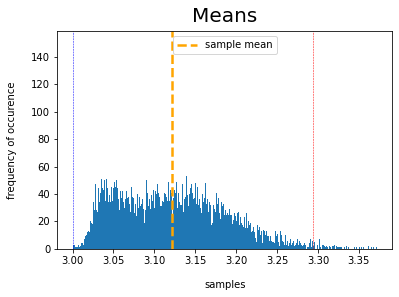

In [5]:
plt.hist(result_list,bins=500)

plt.title("Means", y=1.015, fontsize=20)
plt.axvline(x=sum(result_list)/len(result_list), linestyle='--', linewidth=2.5, label="sample mean", c='orange')
plt.xlabel("samples", labelpad=14)
plt.ylabel("frequency of occurence", labelpad=14)
plt.legend();

result_list.sort()

plt.axvline(x=result_list[int(len(result_list)*0.01)], linestyle='--', linewidth=0.5, label="1%", c='b')
plt.axvline(x=result_list[int(len(result_list)*0.99)], linestyle='--', linewidth=0.5, label="99%", c='r')


plt.show()

In [6]:
def weight_init(m):
    if isinstance(m, torch.nn.Conv2d):
        torch.nn.init.xavier_normal_(m.weight)
        torch.nn.init.zeros_(m.bias)
    elif isinstance(m, torch.nn.Linear):
        torch.nn.init.normal_(m.weight, mean=0.0, std=0.2)
        torch.nn.init.normal_(m.bias, mean=0.0, std=0.01)

    elif isinstance(m, nn.MultiheadAttention):
        m.in_proj_weight.data.normal_(mean=0.0, std=0.02)
        m.out_proj.weight.data.normal_(mean=0.0, std=0.02)


        

class Net(torch.nn.Module):
    def __init__(self):

        super(Net, self).__init__()
        
        self.input_dim = (Agent_number_n-1)
        self.hidden_dim = 64
        self.output_dim = 1
        self.hidden_layer_count = 6 
        
        current_dim = self.input_dim
        self.layers = torch.nn.ModuleList()
        for i in range(self.hidden_layer_count):
            self.layers.append(torch.nn.Linear(current_dim, self.hidden_dim))
            current_dim = self.hidden_dim
        self.layers.append(torch.nn.Linear(current_dim, self.output_dim))

    def calculate(self, value_list):
        h = value_list
        for layer in self.layers:
            h = torch.relu(layer(h))
        return h

    def forward(self, input_list,input_label,label):
        global iteration,echo,target_order
        loss1 = 0
        loss2 = 0
        loss3 = 0
        input_list = torch.from_numpy(
            np.array(input_list)).to(dev).type(torch.float32)
        h_list = []

        for i in range(Agent_number_n):
            h = self.calculate(input_list[i])
            h_list.append(h)
#             loss3 += torch.square(h_function_2(input_list)-h2[1])
            
        input_label = torch.from_numpy(
            np.array(input_label)).to(dev).type(torch.float32)
        sum_h = torch.sum(torch.cat(h_list)).to(dev)


        loss1 = torch.where((Agent_number_n-1)*input_label>sum_h,
                        torch.square(((Agent_number_n-1)*input_label-sum_h)),
                        torch.zeros(1).to(dev)
                      )

        loss2 = torch.where((Agent_number_n-Alpha)*input_label<sum_h,
                        torch.square((sum_h-(Agent_number_n-Alpha)*input_label))/10000,
                        torch.zeros(1).to(dev)
                      )


        return loss1,loss2

In [7]:
def redistribution_value_function(input_tensor):
    S = torch.max(torch.sum(input_tensor), torch.ones(1).to(dev))
    temp_list = []


    for i in range(Agent_number_n):
        temp = []
        
        for j in range(Agent_number_n):
            if(i != j):
                temp .append(input_tensor[j])
                
        temp = torch.stack(temp)
        temp_list.append(temp)
    return torch.stack(temp_list), S

GeneratorNet = nn.Sequential(                      # Generator
    # random ideas (could from normal distribution)
    nn.Linear(N_IDEAS, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    # making a painting from these random ideas
    nn.Linear(64, ART_COMPONENTS),
    nn.Sigmoid(),
)

In [8]:
random.seed(2000)
torch.manual_seed(256)
DiscriminatorNet  = Net()
DiscriminatorNet.apply(weight_init)
GeneratorNet.apply(weight_init)
DiscriminatorNet = torch.load("save/Deep_learning_D_4_1")
GeneratorNet = torch.load("save/Deep_learning_G_4_1")
DiscriminatorNet.to(dev)
GeneratorNet.to(dev)

opt_D = torch.optim.Adam(DiscriminatorNet.parameters(), lr=LR_D)
opt_G = torch.optim.Adam(GeneratorNet.parameters(), lr=LR_G)


scheduler_D = torch.optim.lr_scheduler.StepLR(opt_D, step_size=10, gamma=0.99)
scheduler_G = torch.optim.lr_scheduler.StepLR(opt_G, step_size=10, gamma=0.99)

index_train_list = []
index_test_list = []
train_losses = []
test_losses = []

In [9]:
for iteration in range(int(echo)):

    temp_number = 0
    total_batch_loss = 0 
        
    loss2_list = []
    loss1_sum = 0
    loss2_sum = 0
    denominator = 0
    for index in range(0, BATCH_SIZE):
        training_data_i, training_label, training_data = appen_train(
            Generate_distribution(Agent_number_n))
        h_loss1, h_loss2 = DiscriminatorNet(training_data_i, training_label,
                                       training_data)
        denominator += 1
        loss1_sum += h_loss1
        loss2_sum += h_loss2

    loss_sum = torch.sum(loss1_sum + loss2_sum)
    loss = (loss_sum) / denominator 
    total_batch_loss +=float(loss_sum)

    opt_D.zero_grad()
    loss.backward()
    opt_D.step()

    temp_number = iteration
    index_train_list.append(iteration)
    train_losses.append(total_batch_loss)

    if (iteration%100 == 0):
        print(temp_number,loss,float(loss1_sum),float(loss2_sum))
    ## Gan 
        if(Is_GAN):## Gan Work traning GeneratorNet

            DiscriminatorNet.requires_grad = True
            GeneratorNet.requires_grad = True


            for step in range(100):
                # real painting from artist
                G_ideas = torch.randn(BATCH_SIZE, N_IDEAS,
                                      requires_grad=True).to(dev)  # random ideas\n
                # fake painting from G (random ideas)

                G_values = GeneratorNet(G_ideas)
                G_values , indices = torch.sort(G_values, descending=True)
            #     print(artist_paintings)
            #     print(G_paintings)

                result_list = []
                for index in range(BATCH_SIZE):
                    h_list = []
                    value_list_tensor, S_tensor = redistribution_value_function(
                        G_values[index])
                    for i in range(Agent_number_n):
                        h = DiscriminatorNet.calculate(
                            value_list_tensor[i].cuda().type(torch.float32))
                        h_list.append(h)
                    h_list = torch.stack(h_list)
                    result_list.append(torch.sum(h_list)/S_tensor.cuda())
                result_list = torch.stack(result_list)

                diff_loss = torch.max(result_list)-torch.min(result_list)
                G_loss = torch.max(- diff_loss)

                opt_G.zero_grad()
                G_loss.backward()
                opt_G.step()

            # real painting from artist
                G_ideas = torch.randn(BATCH_SIZE, N_IDEAS,
                                      requires_grad=True).to(dev)  # random ideas\n
                # fake painting from G (random ideas)

                G_values = GeneratorNet(G_ideas)
                G_values , indices = torch.sort(G_values, descending=True)
            #     print(artist_paintings)
            #     print(G_paintings)

                result_list = []
                for index in range(BATCH_SIZE):
                    h_list = []
                    value_list_tensor, S_tensor = redistribution_value_function(
                        G_values[index])
                    for i in range(Agent_number_n):
                        h = DiscriminatorNet.calculate(
                            value_list_tensor[i].cuda().type(torch.float32))
                        h_list.append(h)
                    h_list = torch.stack(h_list)
                    result_list.append(torch.sum(h_list)/S_tensor.cuda())
                result_list = torch.stack(result_list)

                diff_loss = torch.max(result_list)-torch.min(result_list)

                D_loss = torch.where((Agent_number_n-1)>torch.min(result_list),
                    torch.square(((Agent_number_n-1)-torch.min(result_list))),
                    torch.zeros(1).to(dev)
                  )   + torch.where((Agent_number_n-Alpha)<torch.max(result_list),
                                torch.square((torch.max(result_list)-(Agent_number_n-Alpha)))/10000,
                                torch.zeros(1).to(dev)
                              )


                opt_D.zero_grad()
                D_loss.backward()
                opt_D.step()

            print(G_loss,D_loss)
            print()

        index_test_list.append(iteration)
        test_losses.append(
            (sum(result_list) / len(result_list) - min(result_list))+ Agent_number_n-1 - min(min(result_list),Agent_number_n-1) )
        
        scheduler_D.step()
        scheduler_G.step()
        print()

        


0 tensor(2.5215e-06, device='cuda:0', grad_fn=<DivBackward0>) 0.00016090471763163805 4.741601458135847e-07
tensor(-0.9875, device='cuda:0', grad_fn=<MaxBackward1>) tensor([0.0006], device='cuda:0', grad_fn=<AddBackward0>)


100 tensor(2.4050e-05, device='cuda:0', grad_fn=<DivBackward0>) 0.0 0.0015392097411677241
tensor(-1.7164, device='cuda:0', grad_fn=<MaxBackward1>) tensor([0.0013], device='cuda:0', grad_fn=<AddBackward0>)


200 tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>) 0.0 0.019468260928988457
tensor(-1.0345, device='cuda:0', grad_fn=<MaxBackward1>) tensor([0.0003], device='cuda:0', grad_fn=<AddBackward0>)


300 tensor(4.8338e-06, device='cuda:0', grad_fn=<DivBackward0>) 0.0 0.00030936606344766915
tensor(-0.6839, device='cuda:0', grad_fn=<MaxBackward1>) tensor([2.5322e-05], device='cuda:0', grad_fn=<AddBackward0>)


400 tensor(2.8066e-06, device='cuda:0', grad_fn=<DivBackward0>) 0.0 0.00017962093988899142
tensor(-0.4790, device='cuda:0', grad_fn=<MaxBackward1>) tensor(

In [10]:
torch.save(DiscriminatorNet, "save/Deep_learning_D_4_1")
if(Is_GAN):
    torch.save(GeneratorNet, "save/Deep_learning_G_4_1")

In [11]:
denominator = 0
result_list = []
for index in range(len(testing_data)):
    h_list = []
    for i in range(Agent_number_n):
        h = DiscriminatorNet.calculate(torch.tensor(testing_data[index][i]).to(dev).type(torch.float32))
        h_list.append(float(h))
    
    #print(sum(h_list),h_list,sum(h_list)/testing_label[index])
    result_list.append(sum(h_list)/testing_label[index])
    

print(max(result_list),min(result_list),max(result_list)-min(result_list))
print(sum(result_list)/len(result_list))

4.164734146566771 2.9968562722206116 1.1678778743461598
3.230903268964965


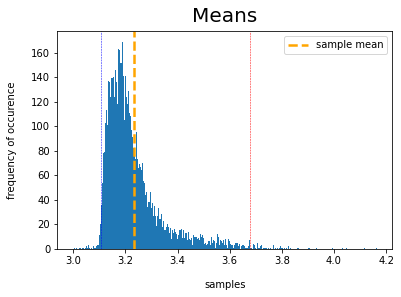

In [12]:
plt.hist(result_list,bins=500)

plt.title("Means", y=1.015, fontsize=20)
plt.axvline(x=sum(result_list)/len(result_list), linestyle='--', linewidth=2.5, label="sample mean", c='orange')
plt.xlabel("samples", labelpad=14)
plt.ylabel("frequency of occurence", labelpad=14)
plt.legend();

result_list.sort()

plt.axvline(x=result_list[int(len(result_list)*0.01)], linestyle='--', linewidth=0.5, label="1%", c='b')
plt.axvline(x=result_list[int(len(result_list)*0.99)], linestyle='--', linewidth=0.5, label="99%", c='r')


plt.show()

In [13]:
#Generate 10000 testing data on GeneratorNet

In [14]:
GeneratorNet = torch.load("save/Deep_learning_G_4_1")
def appen_test_G(x_list):
    global temp_list
                
    S= max(sum(x_list),1.0);
    temp_list = []
    
    for i in range(Agent_number_n):
        temp = []
        for j in range(Agent_number_n):
            if(i!=j):
                temp.append(x_list[j])
        appen(temp,S)
    testing_data_G.append(temp_list)
    testing_label_G.append(S)
# fake painting from G (random ideas)

def read_testing_data_G():
    for i in range(10000):
        #appen_test_G(sorted(np.random.rand(Agent_number_n), reverse=True));
        G_ideas = torch.randn(N_IDEAS).to(dev)  # random ideas\n
        G_values = GeneratorNet(G_ideas)
        G_values , indices = torch.sort(G_values, descending=True)
        appen_test_G(G_values.detach().cpu().numpy()) 
        
testing_data_G = []
testing_label_G = []
read_testing_data_G()
testing_data_G=np.array(testing_data_G)
testing_label_G=np.array(testing_label_G)
print(testing_data_G)
print(testing_label_G)

[[[6.36537671e-01 1.16514787e-01 2.99266400e-03]
  [8.37776959e-01 1.16514787e-01 2.99266400e-03]
  [8.37776959e-01 6.36537671e-01 2.99266400e-03]
  [8.37776959e-01 6.36537671e-01 1.16514787e-01]]

 [[3.06522619e-04 2.06526223e-04 7.69525104e-06]
  [5.02986848e-01 2.06526223e-04 7.69525104e-06]
  [5.02986848e-01 3.06522619e-04 7.69525104e-06]
  [5.02986848e-01 3.06522619e-04 2.06526223e-04]]

 [[1.77487448e-01 1.95254143e-02 2.24104407e-03]
  [6.23730719e-01 1.95254143e-02 2.24104407e-03]
  [6.23730719e-01 1.77487448e-01 2.24104407e-03]
  [6.23730719e-01 1.77487448e-01 1.95254143e-02]]

 ...

 [[6.47209957e-02 1.04759936e-04 1.99146803e-06]
  [1.68593049e-01 1.04759936e-04 1.99146803e-06]
  [1.68593049e-01 6.47209957e-02 1.99146803e-06]
  [1.68593049e-01 6.47209957e-02 1.04759936e-04]]

 [[7.97727883e-01 6.90093439e-04 1.80956818e-07]
  [8.63326728e-01 6.90093439e-04 1.80956818e-07]
  [8.63326728e-01 7.97727883e-01 1.80956818e-07]
  [8.63326728e-01 7.97727883e-01 6.90093439e-04]]

 [[3

In [15]:
result_list_G = []
for index in range(len(testing_data_G)):
    h_list = []
    for i in range(Agent_number_n):
        h = DiscriminatorNet.calculate(torch.tensor(testing_data_G[index][i]).to(dev).type(torch.float32))
        h_list.append(float(h))
    
    #print(sum(h_list),h_list,sum(h_list)/testing_label[index])
    result_list_G.append(sum(h_list)/testing_label_G[index])
    

print(max(result_list_G),min(result_list_G),max(result_list_G)-min(result_list_G))
print(sum(result_list_G)/len(result_list_G))

3.7431710958480835 3.078307032585144 0.6648640632629395
3.3212340594829133


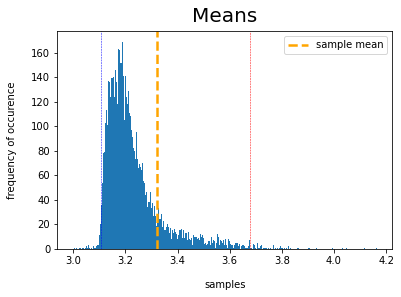

In [16]:
plt.hist(result_list,bins=500)

plt.title("Means", y=1.015, fontsize=20)
plt.axvline(x=sum(result_list_G)/len(result_list_G), linestyle='--', linewidth=2.5, label="sample mean", c='orange')
plt.xlabel("samples", labelpad=14)
plt.ylabel("frequency of occurence", labelpad=14)
plt.legend();

result_list.sort()

plt.axvline(x=result_list[int(len(result_list_G)*0.01)], linestyle='--', linewidth=0.5, label="1%", c='b')
plt.axvline(x=result_list[int(len(result_list_G)*0.99)], linestyle='--', linewidth=0.5, label="99%", c='r')


plt.show()